**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

NameError: ignored

Data Visualisation

Found 2241 files belonging to 9 classes.


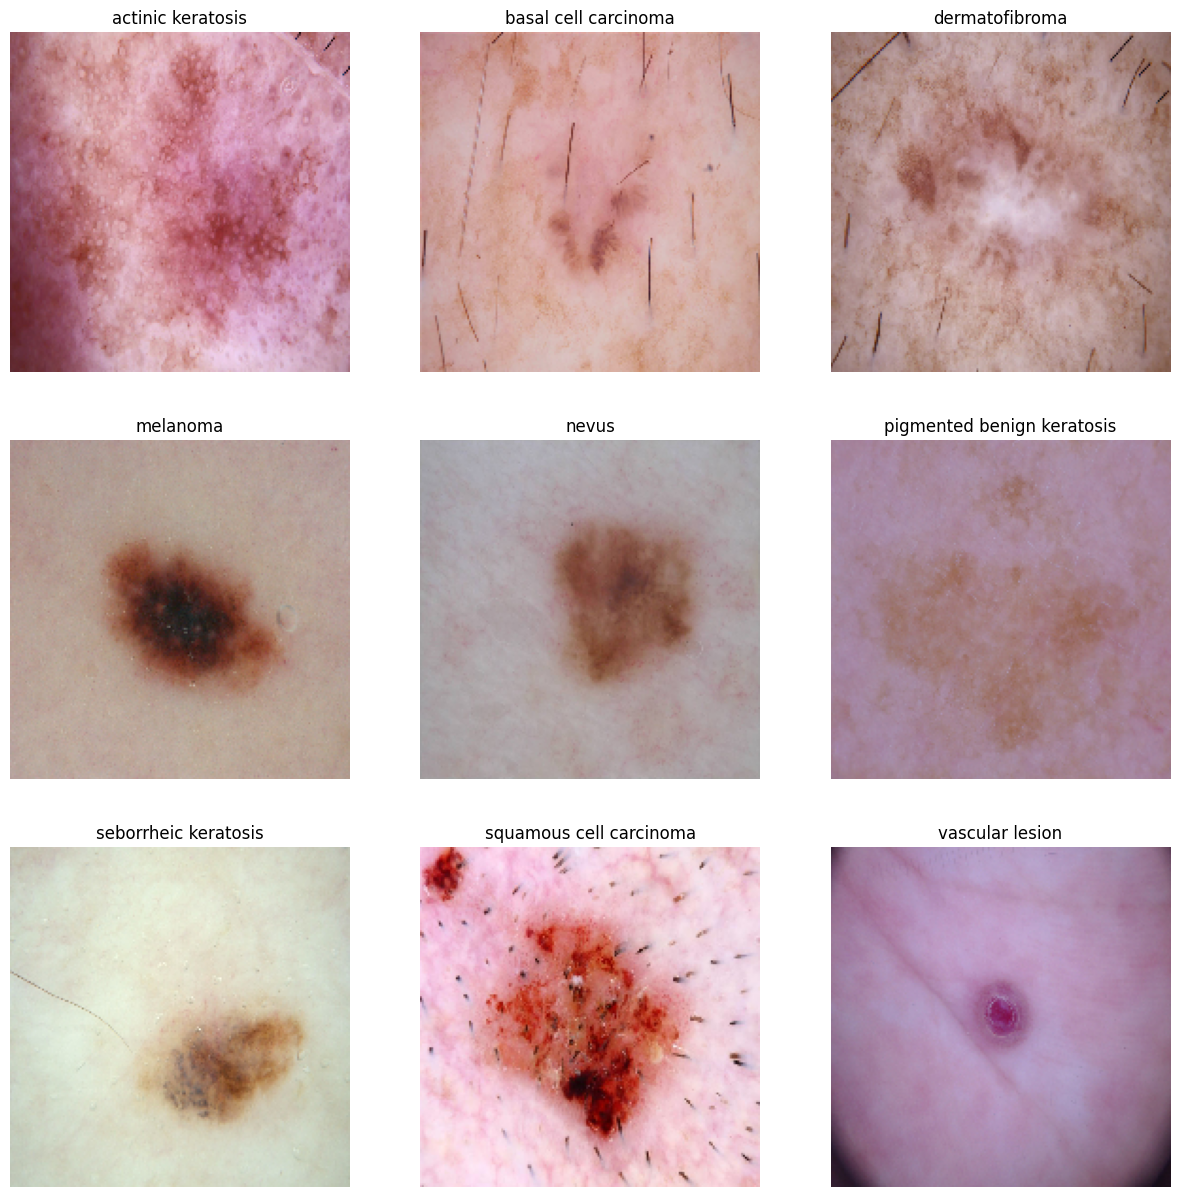

In [ ]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

Creating dataset

In [ ]:
#Train - test split

# train dataset
training_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2241 files belonging to 9 classes.
Using 1793 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2241 files belonging to 9 classes.
Using 448 files for validation.


In [ ]:
class_names = training_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
traiing_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 20
history = model.fit(training_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 2.0745 - accuracy: 0.2359
Epoch 1: val_accuracy improved from -inf to 0.38170, saving model to model.h5
57/57 [==============================] - 683s 2s/step - loss: 2.0745 - accuracy: 0.2359 - val_loss: 1.7827 - val_accuracy: 0.3817
Epoch 2/20
56/57 [============================>.] - ETA: 0s - loss: 1.7822 - accuracy: 0.3765
Epoch 2: val_accuracy improved from 0.38170 to 0.45089, saving model to model.h5
57/57 [==============================] - 3s 55ms/step - loss: 1.7782 - accuracy: 0.3765 - val_loss: 1.6134 - val_accuracy: 0.4509
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.6249 - accuracy: 0.4428
Epoch 3: val_accuracy did not improve from 0.45089
57/57 [==============================] - 3s 52ms/step - loss: 1.6249 - accuracy: 0.4428 - val_loss: 1.7014 - val_accuracy: 0.3795
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 1.6292 - accuracy: 0.4423
Epoch 4: val_accuracy im

The model accuracy and validation accuracy is too low its not learning the images correctly this is causing underfitting issue

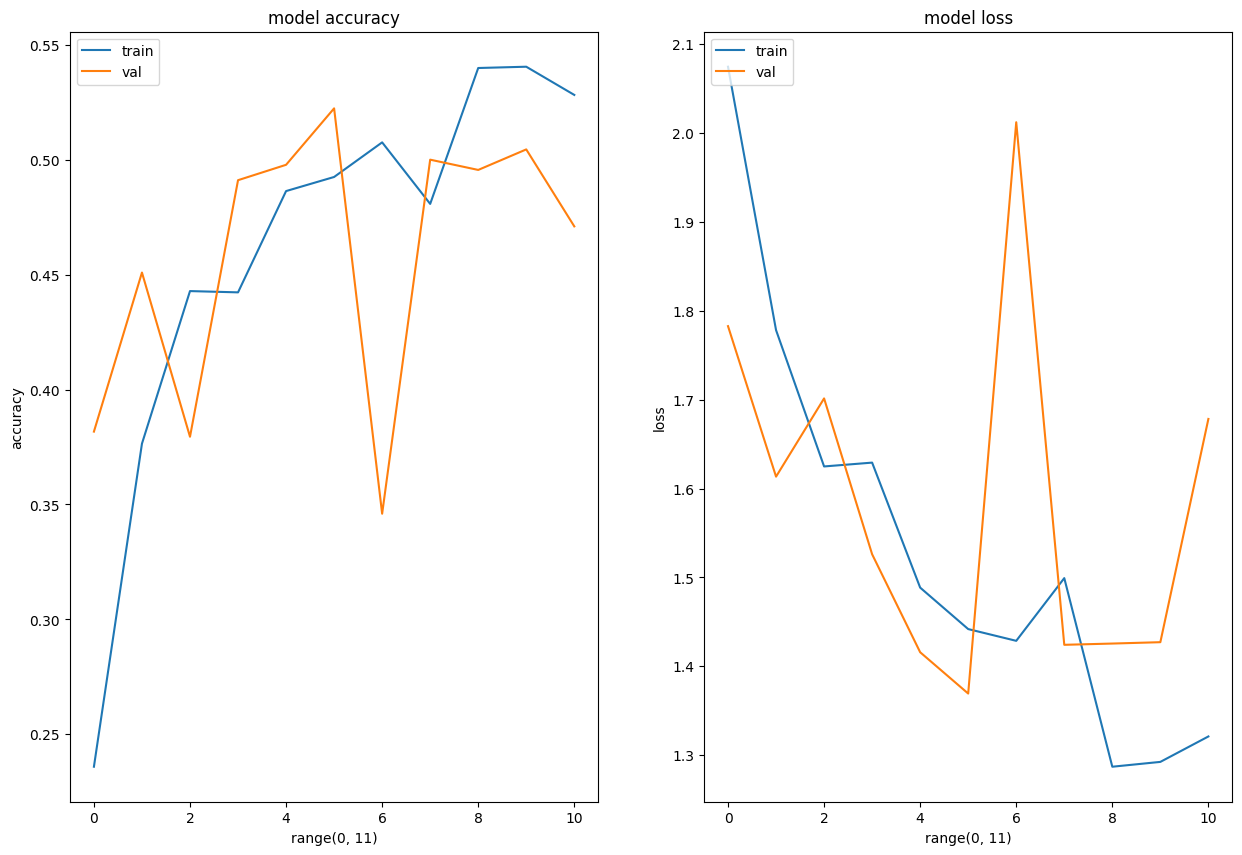

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


We will try to solve underfitting using data augmentation technique that will create variations in the images and try to learn the patterns in the image


In [ ]:
batch_size = 32
img_height = 180
img_width = 180
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

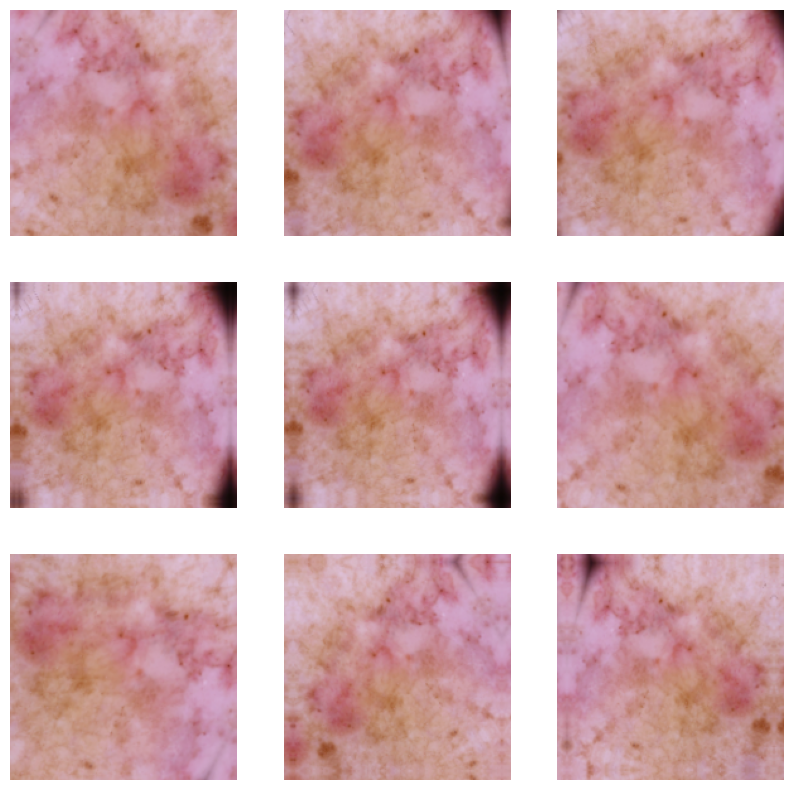

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Train the model
epochs = 20
history = model.fit(training_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 1.1717 - accuracy: 0.5795
Epoch 1: val_accuracy did not improve from 0.52902
57/57 [==============================] - 3s 50ms/step - loss: 1.1717 - accuracy: 0.5795 - val_loss: 1.4081 - val_accuracy: 0.5067
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.1071 - accuracy: 0.5906
Epoch 2: val_accuracy did not improve from 0.52902
57/57 [==============================] - 3s 48ms/step - loss: 1.1071 - accuracy: 0.5906 - val_loss: 1.4342 - val_accuracy: 0.5000
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.0877 - accuracy: 0.6079
Epoch 3: val_accuracy did not improve from 0.52902
57/57 [==============================] - 3s 49ms/step - loss: 1.0877 - accuracy: 0.6079 - val_loss: 1.5199 - val_accuracy: 0.4888
Epoch 4/20
56/57 [============================>.] - ETA: 0s - loss: 1.0489 - accuracy: 0.6173
Epoch 4: val_accuracy did not improve from 0.52902
57/57 [=======================

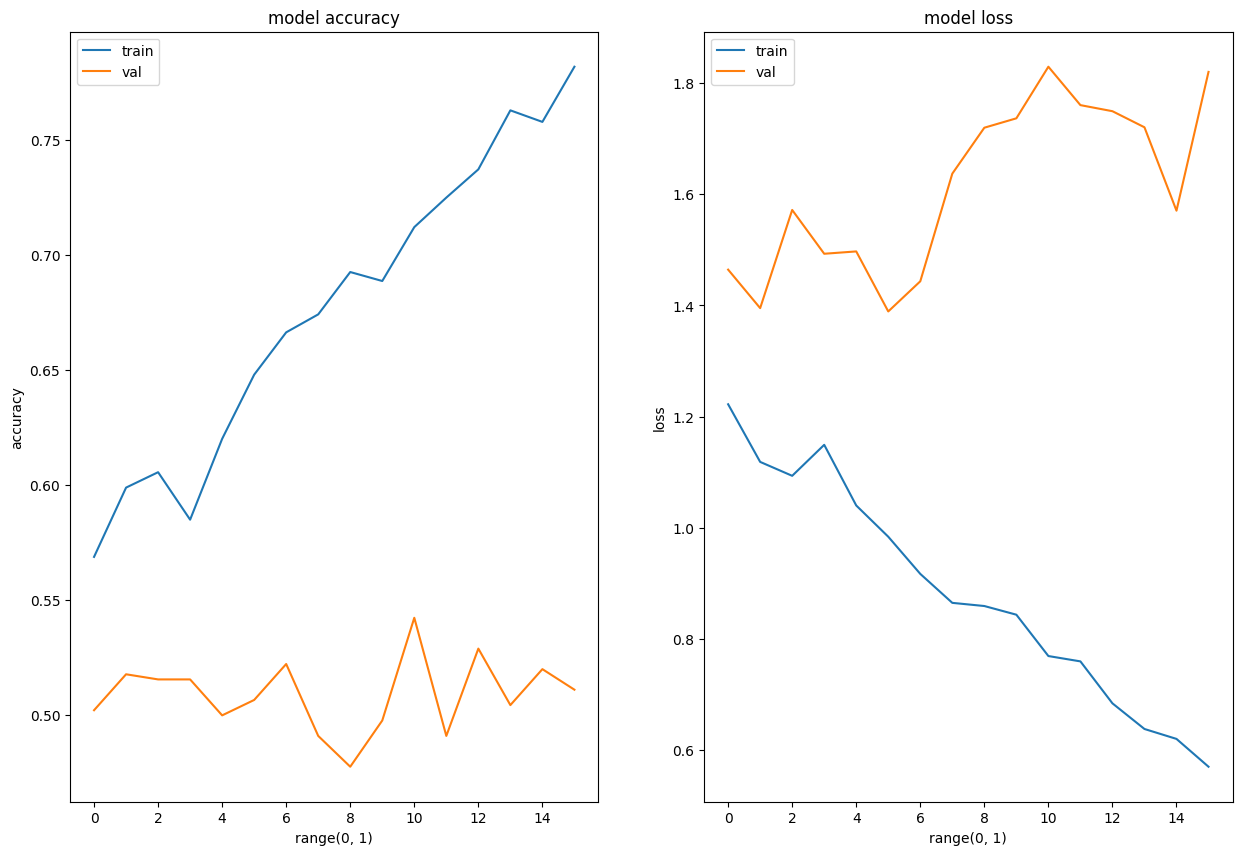

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Data augmentation did not help to solve the underfit issue instead its leading to overfitting issue now with training accuracy being 73% and validation accuracy being 50%, clearly model is not able to generalise

**Todo:** Find the distribution of classes in the training dataset.


**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    sorted_data = sorted(zip(sub_directory, count), key=lambda x: x[1])
    return pd.DataFrame(sorted_data, columns=['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,seborrheic keratosis,77
1,dermatofibroma,95
2,actinic keratosis,114
3,vascular lesion,141
4,squamous cell carcinoma,181
5,nevus,357
6,basal cell carcinoma,376
7,melanoma,438
8,pigmented benign keratosis,462


<Axes: xlabel='No. of Image', ylabel='Class'>

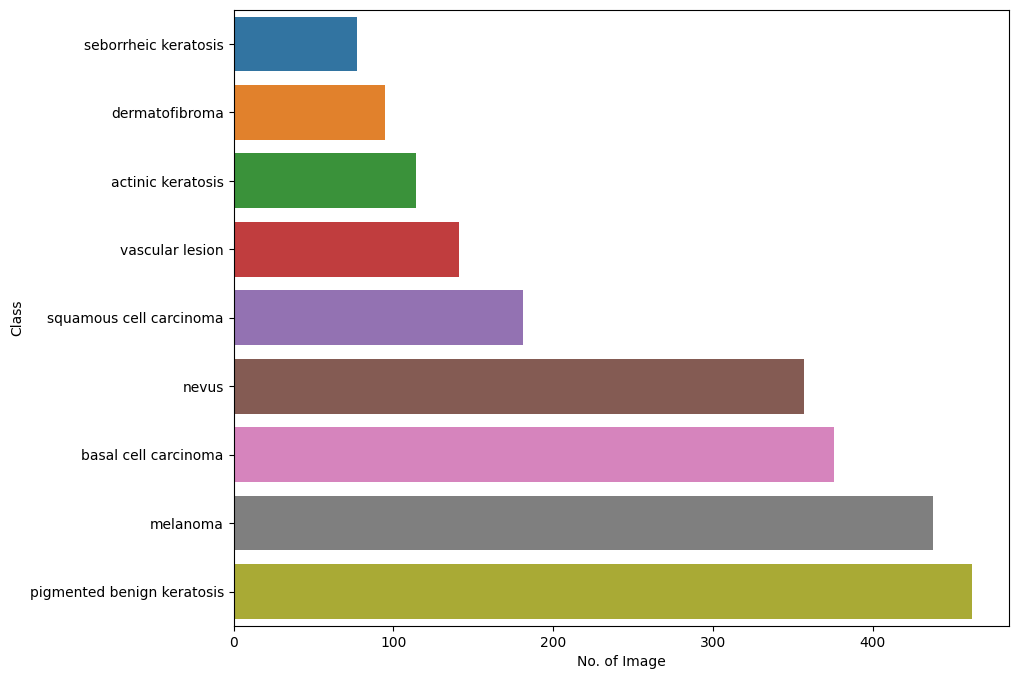

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")




*  Class with lowest number of images is seborrheic keratosis
*  Class with highest number of images is pigmented benign keratosis






We will rectify class imbalance issue using augmentor

In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
import Augmentor

path_to_training_dataset = "/content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i, output_directory=path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2092F5A890>: 100%|██████████| 500/500 [00:18<00:00, 27.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C20926BEB30>: 100%|██████████| 500/500 [00:21<00:00, 22.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C21ED0D0850>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C20926B2E60>: 100%|██████████| 500/500 [01:17<00:00,  6.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7C2092F5A740>: 100%|██████████| 500/500 [01:21<00:00,  6.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C209268A890>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C20926FF730>: 100%|██████████| 500/500 [00:39<00:00, 12.60 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2092F5A890>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]


Initialised with 141 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama_CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2092F7ED10>: 100%|██████████| 500/500 [00:17<00:00, 29.18 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)



6741


In [ ]:
# train dataset
training_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6741 files belonging to 9 classes.
Using 5393 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6741 files belonging to 9 classes.
Using 1348 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 30
history = model.fit(training_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 2.0044 - accuracy: 0.2453
Epoch 1: val_accuracy improved from -inf to 0.35386, saving model to model.h5
169/169 [==============================] - 48s 101ms/step - loss: 2.0044 - accuracy: 0.2453 - val_loss: 1.6636 - val_accuracy: 0.3539
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.5837 - accuracy: 0.4078
Epoch 2: val_accuracy improved from 0.35386 to 0.43027, saving model to model.h5
169/169 [==============================] - 9s 55ms/step - loss: 1.5837 - accuracy: 0.4078 - val_loss: 1.4997 - val_accuracy: 0.4303
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.4217 - accuracy: 0.4688
Epoch 3: val_accuracy improved from 0.43027 to 0.52300, saving model to model.h5
169/169 [==============================] - 9s 55ms/step - loss: 1.4217 - accuracy: 0.4688 - val_loss: 1.3078 - val_accuracy: 0.5230
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 1.27

Overfitting issue is solved by class reimbalancing with training accuracy of 90% and validation accuracy of about 84%

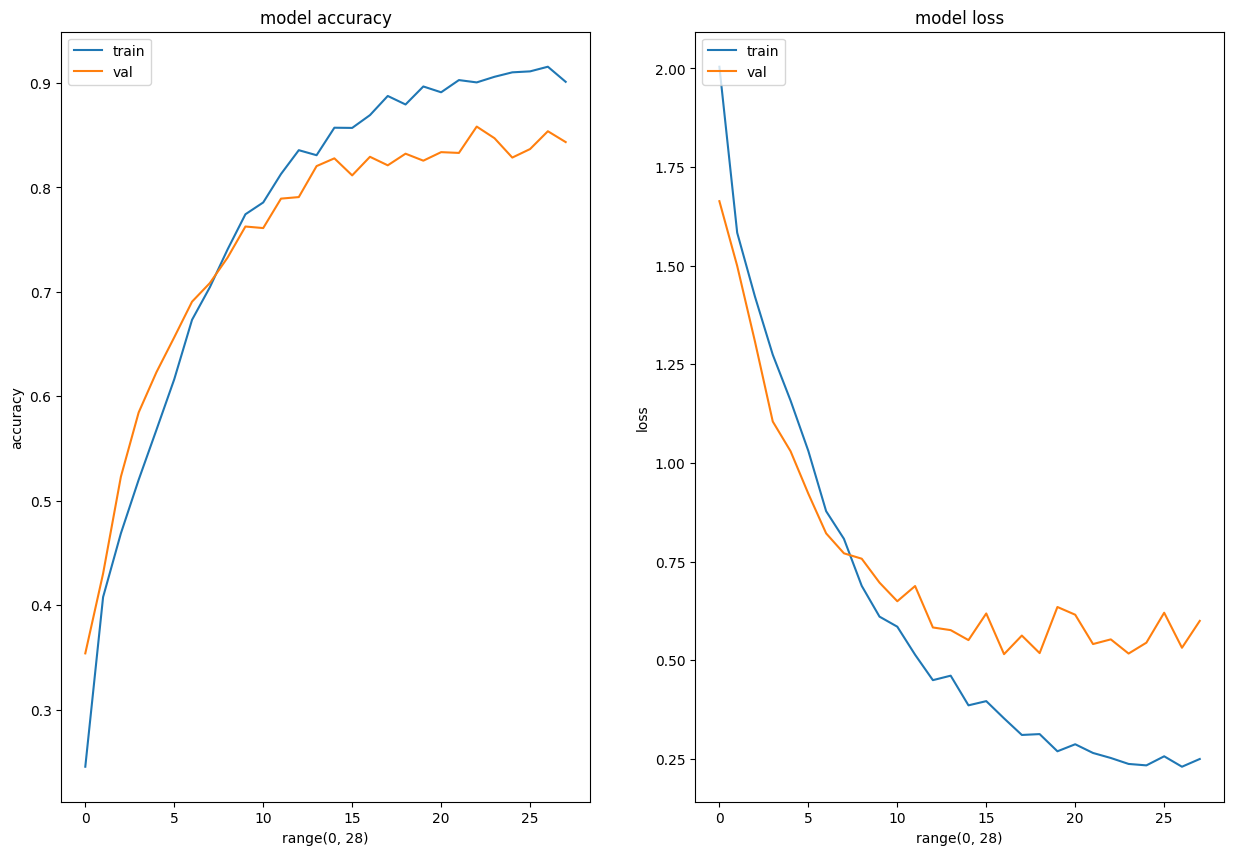

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


1/1 [==============================] - 1s 500ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


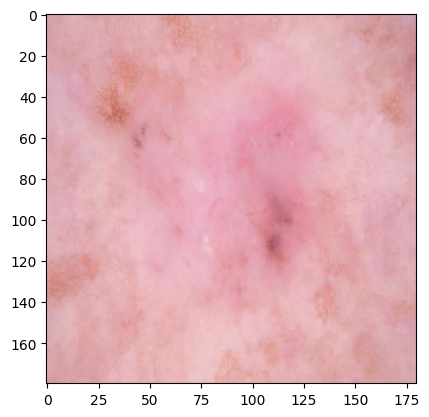

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )